In [2]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy import stats 


### Exclusion Criteria
 - Accuracy: 70 % (17/24 correct)
 - RT: Exclude trial if < 250 ms or > 2s
 - Remove participant if more than 10% of the data is removed (?) 
    

### Pilot Analysis Plots

1. Overall Accuracy
    - accuracy by scene category
    - accuracy by zoom 
    - accuracy by zoom x match
2. RT Distribution
    - RT by scene category
    - RT by zoom 
    - RT by zoom x match
3. 2x3 ANOVA
 

In [3]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

                
        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame

In [4]:
# data_path = '/Users/prachi/Documents/object_scene_scaling_data/pilot2'

data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/OSS_MTurk/data'

In [5]:
input_data = combineCSVs(data_path)

Number of participants before cleaning:  274


In [6]:
# input_data

In [7]:
num_trials = 24

In [8]:
def cleanbyPracticeTries(df, num_allowed_tries):
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    prac_too_many_dist = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_practice_tries = cleaned_subj_df.pracTries.unique()[0]
        
        if subj_num_practice_tries > num_allowed_tries:
            prac_too_many_dist.append(subj_num_practice_tries)
            remove.append(subj)
        else:  
            df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print('Number of participants with more than ' + str(num_allowed_tries) + ' practice tries:', len(remove))
    
    return df2, prac_too_many_dist
    

In [9]:
pracTries_cleaned_data, prac_dist = cleanbyPracticeTries(input_data, 3)

Number of participants with more than 3 practice tries: 9


In [10]:
x = [d for d in prac_dist if d > 5]

len(x), len(prac_dist)

(3, 9)

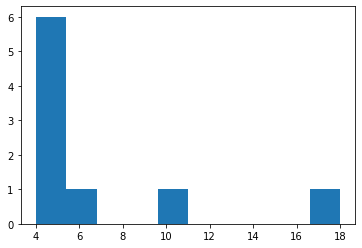

In [11]:
plt.hist(prac_dist)
plt.show()

In [12]:
len(pracTries_cleaned_data.subjID.unique())

265

In [13]:
def Accuracy_Cleaning(df, accuracy_threshold, num_trials):
    """    
    Remove participants with overall accuracy below the accuracy threshold (e.g. 0.7)
    
    Returns:
        data of participants that passed the accuracy threshold 
        list of the number of correct trials each participant got
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    list_trials_correct = []
    # number of participants where exclusion is because all responses were 'none'
    c = 0
    
    for subj in all_subjIDs:
        keypresses = []

        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_correct_trials = 0
        
        acc_column = np.array(list(subj_df['accuracy']))
        sum_acc = np.sum(acc_column)
        
        
        for idx, row in subj_df.iterrows():
            trial_acc = row['accuracy']
            if trial_acc == 1:
                subj_num_correct_trials += 1
            else:
                keypresses.append(row['keyPress'])
        
        subj_acc = sum_acc/num_trials
#         print(acc_column)
#         print(subj, sum_acc, subj_acc)
                
        # minimum number of trials correct the participant must have to be included
        if subj_acc < accuracy_threshold:
#             print(subj_acc, subj)
            remove.append(subj)
#             print(len([x for x in keypresses if x == 'none']))
            if len([x for x in keypresses if x == 'none']) >= 4:
                c += 1
            
#         else:
#             print(subj_acc)
        
        list_trials_correct.append(subj_num_correct_trials)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    
    print("Number of Participants with accuracy below 70%: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    print('Number of participants that did not respond for 4 or more trials:', c)
    
    print('Number of participants left: ', len(df2.subjID.unique()))
                
    return df2, list_trials_correct, keypresses

In [14]:
Accuracy_cleaned_data, correct_trials_distribution, keypresses = Accuracy_Cleaning(pracTries_cleaned_data, 0.7, num_trials)


Number of Participants with accuracy below 70%:  27
Number of participants that did not respond for 4 or more trials: 4
Number of participants left:  238


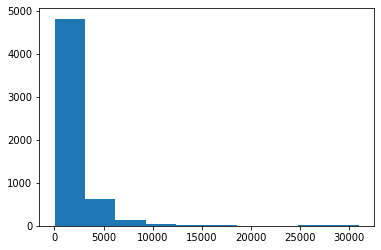

In [15]:
plt.hist(list(Accuracy_cleaned_data['RT']))
plt.show()

In [16]:
def RT_Cleaning(df, outlier_range, num_trials):
    """
    Remove trials where trial RT is outside of the defined outlier range 
    
    Returns:
        dataframe with outlier RT trials removed
        list of all RTs 
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    print(len(all_subjIDs))
    
    remove = []
    df2_list = []
    total_RT_outliers = 0
    total = 0
    list_trialRT = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        for idx, row in subj_df.iterrows():
            total += 1
            RT = row["RT"]
            list_trialRT.append(RT)
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print(len(df2.subjID.unique()))
                
    return df2, list_trialRT

In [17]:
RT_cleaned_data, trialRTs_distribution = RT_Cleaning(Accuracy_cleaned_data, [250, 5000], num_trials)


238
238


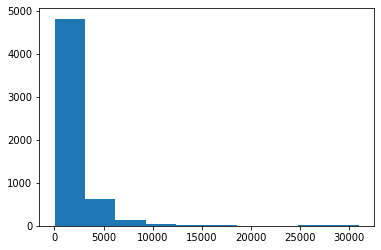

In [18]:
plt.hist(trialRTs_distribution)
plt.show()

In [19]:
all_subjIDs = RT_cleaned_data.subjID.unique()
dist = []
for subj in all_subjIDs:
    count = 0
    subj_df = RT_cleaned_data.loc[RT_cleaned_data['subjID'] == subj]
    dist.append(len(subj_df))
#     print(len(subj_df))

In [20]:
len([d for d in dist if d >11])

230

In [21]:
# pracTries_cleaned_data.subjID.unique(), RT_cleaned_data.subjID.unique()

In [22]:
def finalTrialCountCheck(df, num_trials, min_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        if count_trials < min_trials:
            remove.append(subj)
            
#         threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)

#         if count_trials <= threshold_trials_remaining:
#             remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
            
    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 
                    
    print("Number of participants left: ",len(df.subjID.unique()))
    return df

In [23]:
finalTrialCount_data = finalTrialCountCheck(RT_cleaned_data, num_trials, 22)

Number of Participants with >= 10% trials removed:  46
Number of participants left:  192


In [24]:
raw_final_data = finalTrialCount_data.copy(deep=True)
len(raw_final_data.subjID.unique())

192

In [25]:
def zscored_outcomes(df):
    '''
    z-score depth estimates and RTs:
        for each subj calculate their avg and std 
        zscored = (estim - subj avg)/subj std
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    df2_list = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        final_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # Z-Score RT
        average_RT = subj_df["RT"].mean()
        std_RT = subj_df["RT"].std()
        subj_RTs = np.array(list(subj_df["RT"]))
        zscored_subj_RTs = (subj_RTs - average_RT)/std_RT
        final_subj_df.insert(4, 'Z-Scored RT',zscored_subj_RTs)
        df2_list.append(final_subj_df)
    
    df2 = pd.concat(df2_list)    

    return df2

In [26]:
zs_final_data = zscored_outcomes(raw_final_data)

In [27]:
def recode_ratings(df):
    '''
    4, 3+5, 2+6, 1+7
    labeled: 4, 3, 2, 1
    where 4 is scaled, and 1 is most mis-scaled
    '''
    
    df['rating'] = df['rating'].replace(5, 3)
    df['rating'] = df['rating'].replace(6, 2)
    df['rating'] = df['rating'].replace(7, 1) 

    return df

In [28]:
recoded_ratings_data = recode_ratings(zs_final_data)

In [29]:
s = 'c3_large_clipboard_L.png'

s[:-6]

'c3_large_clipboard'

In [30]:
recoded_ratings_data.rating.unique()

array([2, 1, 3, 4])

In [31]:
def add_image_col(df):
    """
    """
    image_col = []
    
    for idx, row in df.iterrows():
        image_col.append(row['image'][:-6])

    
    return np.array(image_col)

In [32]:
image_column = add_image_col(recoded_ratings_data)

# # add misscaled column to dataframe 
recoded_ratings_data.insert(14, "image_name", image_column)


In [33]:
final_data = recoded_ratings_data.copy(deep=True)

In [34]:
final_data.to_csv('zs_e5v2Final.csv', index=False)

In [35]:
len(final_data.subjID.unique())

192

In [76]:
# final_data = pd.read_csv('/Users/pmahableshwarkar/Documents/object_scene_scaling/zs_e5v2Final_unfolded.csv')

final_data = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/OSS/zs_e5v2Final_unfolded.csv')

## Accuracy


add error bars
- overall accuracy per subj in each condition 

In [77]:
# data split by object-scene size congruency aka scene zoom 

zo_df = final_data.loc[final_data['presentationSize']=='large']
zi_df = final_data.loc[final_data['presentationSize']=='small']

zo_acc = np.sum(np.array(zo_df['accuracy']))/len(np.array(zo_df['accuracy']))
zi_acc = np.sum(np.array(zi_df['accuracy']))/len(np.array(zi_df['accuracy']))

zo_acc, zi_acc

(0.9741568112133158, 0.9658687943262412)

In [78]:
misscaled_zo = zo_df.loc[zo_df['scale'] =='misscaled'] 
misscaled_zi = zi_df.loc[zi_df['scale'] =='misscaled']
misscaled = misscaled_zo.append(misscaled_zi)

scaled_zo = zo_df.loc[zo_df['scale'] =='scaled'] 
scaled_zi = zi_df.loc[zi_df['scale'] =='scaled']
scaled = scaled_zo.append(scaled_zi)

misscaled_acc = np.sum(np.array(misscaled['accuracy']))/len(np.array(misscaled['accuracy']))
scaled_acc = np.sum(np.array(scaled['accuracy']))/len(np.array(scaled['accuracy']))

misscaled_acc, scaled_acc

(0.9635164835164836, 0.9765901060070671)

In [79]:
# object scene semantic congruency 
# var = objectScene1SemanticCongruency
# acc = np.sum(np.array(misscaled_zo_objSemCong['accuracy']))/len(np.array(misscaled_zo_objSemCong['accuracy']))

misscaled_zo_objSemCong = misscaled_zo.loc[misscaled_zo["objSceneSemCong"]==1]
misscaled_zo_objSemIncong = misscaled_zo.loc[misscaled_zo["objSceneSemCong"]==0]

misscaled_zo_objSemCong_acc = np.sum(np.array(misscaled_zo_objSemCong['accuracy']))/len(np.array(misscaled_zo_objSemCong['accuracy']))
misscaled_zo_objSemIncong_acc =np.sum(np.array(misscaled_zo_objSemIncong['accuracy']))/len(np.array(misscaled_zo_objSemIncong['accuracy']))

misscaled_zo_objSemCong_sem = np.std(np.array(misscaled_zo_objSemCong['accuracy']))/np.sqrt(len(np.array(misscaled_zo_objSemCong['accuracy'])))
misscaled_zo_objSemIncong_sem = np.std(np.array(misscaled_zo_objSemIncong['accuracy']))/np.sqrt(len(np.array(misscaled_zo_objSemIncong['accuracy'])))


misscaled_zi_objSemCong = misscaled_zi.loc[misscaled_zi["objSceneSemCong"]==1]
misscaled_zi_objSemIncong = misscaled_zi.loc[misscaled_zi["objSceneSemCong"]==0]

misscaled_zi_objSemCong_acc = np.sum(np.array(misscaled_zi_objSemCong['accuracy']))/len(np.array(misscaled_zi_objSemCong['accuracy']))
misscaled_zi_objSemIncong_acc = np.sum(np.array(misscaled_zi_objSemIncong['accuracy']))/len(np.array(misscaled_zi_objSemIncong['accuracy']))

misscaled_zi_objSemCong_sem = np.std(np.array(misscaled_zi_objSemCong['accuracy']))/np.sqrt(len(np.array(misscaled_zi_objSemCong['accuracy'])))
misscaled_zi_objSemIncong_sem = np.std(np.array(misscaled_zi_objSemIncong['accuracy']))/np.sqrt(len(np.array(misscaled_zi_objSemIncong['accuracy'])))

# scaled
scaled_zo_objSemCong = scaled_zo.loc[scaled_zo["objSceneSemCong"]==1]
scaled_zo_objSemIncong = scaled_zo.loc[scaled_zo["objSceneSemCong"]==0]

scaled_zo_objSemCong_acc = np.sum(np.array(scaled_zo_objSemCong['accuracy']))/len(np.array(scaled_zo_objSemCong['accuracy']))
scaled_zo_objSemIncong_acc =np.sum(np.array(scaled_zo_objSemIncong['accuracy']))/len(np.array(scaled_zo_objSemIncong['accuracy']))

scaled_zo_objSemCong_sem = np.std(np.array(scaled_zo_objSemCong['accuracy']))/np.sqrt(len(np.array(scaled_zo_objSemCong['accuracy'])))
scaled_zo_objSemIncong_sem = np.std(np.array(scaled_zo_objSemIncong['accuracy']))/np.sqrt(len(np.array(scaled_zo_objSemIncong['accuracy'])))


scaled_zi_objSemCong = scaled_zi.loc[scaled_zi["objSceneSemCong"]==1]
scaled_zi_objSemIncong = scaled_zi.loc[scaled_zi["objSceneSemCong"]==0]

scaled_zi_objSemCong_acc = np.sum(np.array(scaled_zi_objSemCong['accuracy']))/len(np.array(scaled_zi_objSemCong['accuracy']))
scaled_zi_objSemIncong_acc = np.sum(np.array(scaled_zi_objSemIncong['accuracy']))/len(np.array(scaled_zi_objSemIncong['accuracy']))

scaled_zi_objSemCong_sem = np.std(np.array(scaled_zi_objSemCong['accuracy']))/np.sqrt(len(np.array(scaled_zi_objSemCong['accuracy'])))
scaled_zi_objSemIncong_sem = np.std(np.array(scaled_zi_objSemIncong['accuracy']))/np.sqrt(len(np.array(scaled_zi_objSemIncong['accuracy'])))

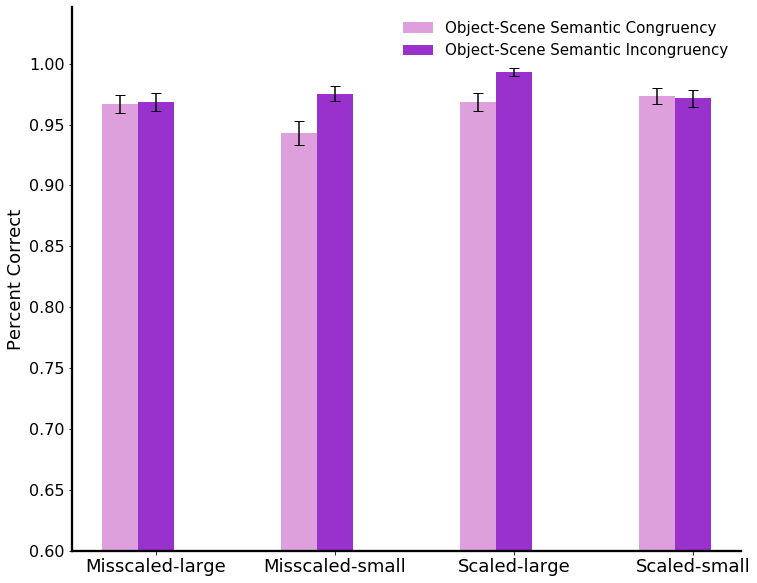

In [80]:
fig, ax = plt.subplots(figsize=[12,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

#                                          Misscaled                                               Scaled
#                                large                          small                         large                       small
Acc_objSemCong =   [misscaled_zo_objSemCong_acc, misscaled_zi_objSemCong_acc, scaled_zo_objSemCong_acc, scaled_zi_objSemCong_acc]
yerr_objSemCong =  [misscaled_zo_objSemCong_sem, misscaled_zi_objSemCong_sem, scaled_zo_objSemCong_sem, scaled_zi_objSemCong_sem]

# yerr_objSemCong =  [0.03042634, 0.009242794, 0.009306265, 0.022845975]

Acc_objSemIncong =   [misscaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_acc, scaled_zo_objSemIncong_acc, scaled_zi_objSemIncong_acc]
yerr_objSemIncong =  [misscaled_zo_objSemIncong_sem, misscaled_zi_objSemIncong_sem, scaled_zo_objSemIncong_sem, scaled_zi_objSemIncong_sem]

# yerr_objSemIncong =  [0.027580192, 0.011109077, 0.008396171, 0.031121827]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_objSemCong, width, color='plum', label='Object-Scene Semantic Congruency', yerr=yerr_objSemCong, capsize=5)
plt.bar(x, Acc_objSemIncong, width, color='darkorchid', label='Object-Scene Semantic Incongruency', yerr=yerr_objSemIncong, capsize=5)


plt.xticks(x, ['Misscaled-large', 'Misscaled-small', 'Scaled-large', 'Scaled-small'], fontsize='18')
plt.ylim(0.60)
plt.yticks(fontsize=16) 
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=1, fontsize=15, frameon=False)
# plt.title('E5V2-Accuracy', fontsize=22)
plt.show()

## RT

CREATE DIFF DF - ONLY INCLUDE CORRECT TRIALS

WITHIN PARTICIPANT SEM

In [81]:
final_data_correctOnly = final_data.loc[final_data['accuracy']==1]

np.mean(np.array(final_data_correctOnly['RT']))

1702.138769021122

In [82]:
# data split by object-scene size congruency aka scene zoom 

zo_df_CO = final_data_correctOnly.loc[final_data_correctOnly['presentationSize']=='large']
zi_df_CO = final_data_correctOnly.loc[final_data_correctOnly['presentationSize']=='small']

zo_RT = np.mean(np.array(zo_df_CO['RT']))
zi_RT = np.mean(np.array(zi_df_CO['RT']))


zo_RT_sem = sem(np.array(zo_df_CO['RT']))
zi_RT_sem = sem(np.array(zi_df_CO['RT']))


zo_RT, zi_RT

(1632.3916366906474, 1773.326296466269)

In [104]:
import scipy.stats as stats
from random import sample


print(len(np.array(zo_df_CO['RT'])), len(np.array(zi_df_CO['RT'])))


trunc_zo = sample(list(zo_df_CO['RT']), len(np.array(zi_df_CO['RT'])))


print("Paired T-Test: Large vs Small Presentation Size")

stats.ttest_rel(trunc_zo, np.array(zi_df_CO['RT']))


2224 2179
Paired T-Test: Large vs Small Presentation Size


Ttest_relResult(statistic=-6.2295308360163055, pvalue=5.598597668881729e-10)

In [113]:
ms_df_CO = final_data_correctOnly.loc[final_data_correctOnly['scale']=='misscaled']
s_df_CO = final_data_correctOnly.loc[final_data_correctOnly['scale']=='scaled']

ms_RT = np.mean(np.array(ms_df_CO['RT']))
s_RT = np.mean(np.array(s_df_CO['RT']))


ms_RT_sem = sem(np.array(ms_df_CO['RT']))
s_RT_sem = sem(np.array(s_df_CO['RT']))

print(ms_RT, s_RT)


print(len(np.array(ms_df_CO['RT'])), len(np.array(s_df_CO['RT'])))


trunc_s = sample(list(s_df_CO['RT']), len(np.array(ms_df_CO['RT'])))


print("Paired T-Test: Misscaled vs Scaled")

stats.ttest_rel(trunc_s, np.array(ms_df_CO['RT']))

1735.7586678832117 1668.8077792853912
2192 2211
Paired T-Test: Misscaled vs Scaled


Ttest_relResult(statistic=-2.949527226697388, pvalue=0.003216320042917979)

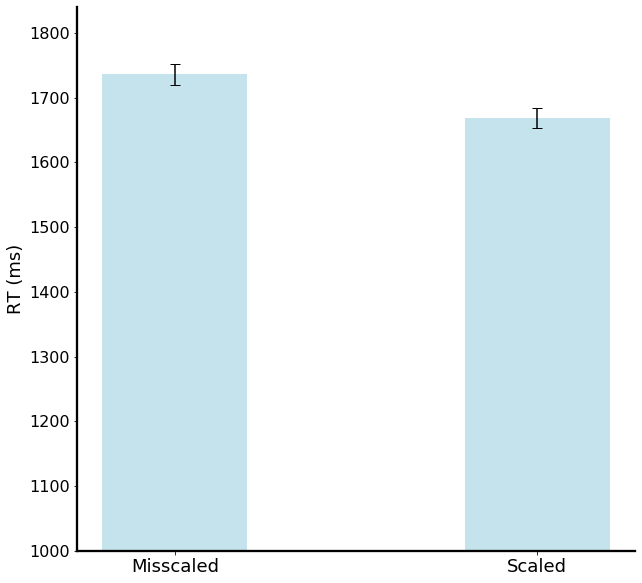

In [111]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
# creating the dataset
data = {'Misscaled':ms_RT, 'Scaled':s_RT}

courses = list(data.keys())
values = list(data.values())
   
# creating the bar plot
# plt.bar(courses, values, color ='lightcoral', alpha=0.7,
#         width = 0.4, yerr=[12.22398389, 12.22398389], capsize=5)

plt.bar(courses, values, color ='lightblue', alpha=0.7,
        width = 0.4, yerr=[ms_RT_sem, s_RT_sem], capsize=5)


plt.xticks(fontsize=18) 
plt.yticks(fontsize=16) 
plt.ylim(1000)
plt.ylabel("RT (ms)", fontsize=18)
# plt.title('E5V2 Presentation Size RT', fontsize=20)
plt.show()

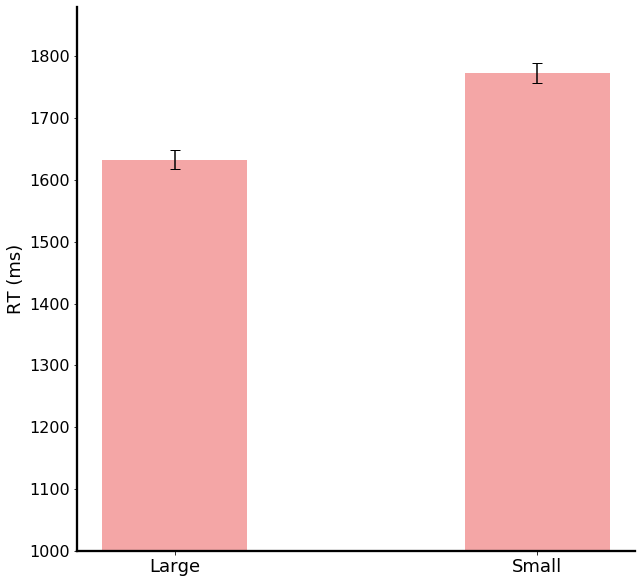

In [84]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
# creating the dataset
data = {'Large':zo_RT, 'Small':zi_RT}

courses = list(data.keys())
values = list(data.values())
   
# creating the bar plot
# plt.bar(courses, values, color ='lightcoral', alpha=0.7,
#         width = 0.4, yerr=[12.22398389, 12.22398389], capsize=5)

plt.bar(courses, values, color ='lightcoral', alpha=0.7,
        width = 0.4, yerr=[zo_RT_sem, zi_RT_sem], capsize=5)


plt.xticks(fontsize=18) 
plt.yticks(fontsize=16) 
plt.ylim(1000)
plt.ylabel("RT (ms)", fontsize=18)
# plt.title('E5V2 Presentation Size RT', fontsize=20)
plt.show()

In [85]:
misscaled_zo_CO = zo_df_CO.loc[zo_df_CO['scale'] =='misscaled'] 
misscaled_zi_CO = zi_df_CO.loc[zi_df_CO['scale'] =='misscaled']
misscaled_CO = misscaled_zo_CO.append(misscaled_zi_CO)

scaled_zo_CO = zo_df_CO.loc[zo_df_CO['scale'] =='scaled'] 
scaled_zi_CO = zi_df_CO.loc[zi_df_CO['scale'] =='scaled']
scaled_CO = scaled_zo_CO.append(scaled_zi_CO)

In [86]:
misscaled_zo_objSemCong_CO = misscaled_zo_CO.loc[misscaled_zo_CO["objSceneSemCong"]==1]
misscaled_zo_objSemIncong_CO = misscaled_zo_CO.loc[misscaled_zo_CO["objSceneSemCong"]==0]

misscaled_zo_objSemCong_RT = np.mean(np.array(misscaled_zo_objSemCong_CO['Z-Scored RT']))
misscaled_zo_objSemIncong_RT = np.mean(np.array(misscaled_zo_objSemIncong_CO['Z-Scored RT']))

misscaled_zo_objSemCong_RT_sem = sem(np.array(misscaled_zo_objSemCong_CO['Z-Scored RT']))
misscaled_zo_objSemIncong_RT_sem = sem(np.array(misscaled_zo_objSemIncong_CO['Z-Scored RT']))


misscaled_zi_objSemCong_CO = misscaled_zi_CO.loc[misscaled_zi_CO["objSceneSemCong"]==1]
misscaled_zi_objSemIncong_CO = misscaled_zi_CO.loc[misscaled_zi_CO["objSceneSemCong"]==0]

misscaled_zi_objSemCong_RT = np.mean(np.array(misscaled_zi_objSemCong_CO['Z-Scored RT']))
misscaled_zi_objSemIncong_RT = np.mean(np.array(misscaled_zi_objSemIncong_CO['Z-Scored RT']))

misscaled_zi_objSemCong_RT_sem = sem(np.array(misscaled_zi_objSemCong_CO['Z-Scored RT']))
misscaled_zi_objSemIncong_RT_sem = sem(np.array(misscaled_zi_objSemIncong_CO['Z-Scored RT']))


# scaled
scaled_zo_objSemCong_CO = scaled_zo_CO.loc[scaled_zo_CO["objSceneSemCong"]==1]
scaled_zo_objSemIncong_CO = scaled_zo_CO.loc[scaled_zo_CO["objSceneSemCong"]==0]

scaled_zo_objSemCong_RT = np.mean(np.array(scaled_zo_objSemCong_CO['Z-Scored RT']))
scaled_zo_objSemIncong_RT = np.mean(np.array(scaled_zo_objSemIncong_CO['Z-Scored RT']))

scaled_zo_objSemCong_RT_sem = sem(np.array(scaled_zo_objSemCong_CO['Z-Scored RT']))
scaled_zo_objSemIncong_RT_sem = sem(np.array(scaled_zo_objSemIncong_CO['Z-Scored RT']))


scaled_zi_objSemCong_CO = scaled_zi_CO.loc[scaled_zi_CO["objSceneSemCong"]==1]
scaled_zi_objSemIncong_CO = scaled_zi_CO.loc[scaled_zi_CO["objSceneSemCong"]==0]

scaled_zi_objSemCong_RT = np.mean(np.array(scaled_zi_objSemCong_CO['Z-Scored RT']))
scaled_zi_objSemIncong_RT = np.mean(np.array(scaled_zi_objSemIncong_CO['Z-Scored RT']))

scaled_zi_objSemCong_RT_sem = sem(np.array(scaled_zi_objSemCong_CO['Z-Scored RT']))
scaled_zi_objSemIncong_RT_sem = sem(np.array(scaled_zi_objSemIncong_CO['Z-Scored RT']))


In [87]:
import scipy.stats as stats
from random import sample

ms_large_osC = np.array(misscaled_zo_objSemCong_CO['Z-Scored RT'])
ms_large_osI = np.array(misscaled_zo_objSemIncong_CO['Z-Scored RT'])
ms_small_osC = np.array(misscaled_zi_objSemCong_CO['Z-Scored RT'])
ms_small_osI = np.array(misscaled_zi_objSemIncong_CO['Z-Scored RT'])

s_large_osC = np.array(scaled_zo_objSemCong_CO['Z-Scored RT'])
s_large_osI = np.array(scaled_zo_objSemIncong_CO['Z-Scored RT'])
s_small_osC = np.array(scaled_zi_objSemCong_CO['Z-Scored RT'])
s_small_osI = np.array(scaled_zi_objSemIncong_CO['Z-Scored RT'])

# print(len(ms_large_osC), len(ms_large_osI), len(ms_small_osC), len(ms_small_osI))
# print(len(s_large_osC), len(s_large_osI), len(s_small_osC), len(s_small_osI))

t_vals_0 = []
corrs_0 = []

t_vals_1 = []
corrs_1 = []

t_vals_2 = []
corrs_2 = []

t_vals_3 = []
corrs_3 = []

reps = 10000
for i in range(reps):
    trunc_ms_large_osC = sample(list(ms_large_osC),len(ms_small_osC))
    trunc_ms_large_osI = sample(list(ms_large_osI),len(ms_small_osC))
    trunc_ms_small_osC = ms_small_osC
    trunc_ms_small_osI = sample(list(ms_small_osI),len(ms_small_osC))

    trunc_s_large_osC = sample(list(s_large_osC),len(ms_small_osC))
    trunc_s_large_osI = sample(list(s_large_osI),len(ms_small_osC))
    trunc_s_small_osC = sample(list(s_small_osC),len(ms_small_osC))
    trunc_s_small_osI = sample(list(s_small_osI),len(ms_small_osC))

    t_vals_0.append(stats.ttest_rel(trunc_ms_small_osC, trunc_ms_small_osI)[0])
    corrs_0.append(stats.ttest_rel(trunc_ms_small_osC, trunc_ms_small_osI)[1])
    
    t_vals_1.append(stats.ttest_rel(trunc_s_small_osC, trunc_s_small_osI)[0])
    corrs_1.append(stats.ttest_rel(trunc_s_small_osC, trunc_s_small_osI)[1])
    
    t_vals_2.append(stats.ttest_rel(trunc_ms_small_osC, trunc_s_small_osC)[0])
    corrs_2.append(stats.ttest_rel(trunc_ms_small_osC, trunc_s_small_osC)[1])
    
    t_vals_3.append(stats.ttest_rel(trunc_ms_small_osI, trunc_s_small_osI)[0])
    corrs_3.append(stats.ttest_rel(trunc_ms_small_osI, trunc_s_small_osI)[1])


print('Misscaled small: ObjSceneCong x ObjSceneIncong')
print(np.mean(np.array(t_vals_0)), np.mean(np.array(corrs_0)))
print()
print('Scaled small: ObjSceneCong x ObjSceneIncong')
print(np.mean(np.array(t_vals_1)), np.mean(np.array(corrs_1)))
print()
print('ObjSceneCong small: Misscaled x Scaled')
print(np.mean(np.array(t_vals_2)), np.mean(np.array(corrs_2)))
print()
print('ObjSceneIncong small: Misscaled x Scaled')
print(np.mean(np.array(t_vals_3)), np.mean(np.array(corrs_3)))

Misscaled small: ObjSceneCong x ObjSceneIncong
2.52354892256663 0.01297549766991604

Scaled small: ObjSceneCong x ObjSceneIncong
2.0006430962901756 0.05012418232184624

ObjSceneCong small: Misscaled x Scaled
2.7539522494053683 0.006652855918353991

ObjSceneIncong small: Misscaled x Scaled
2.568915935851977 0.012331976852698356


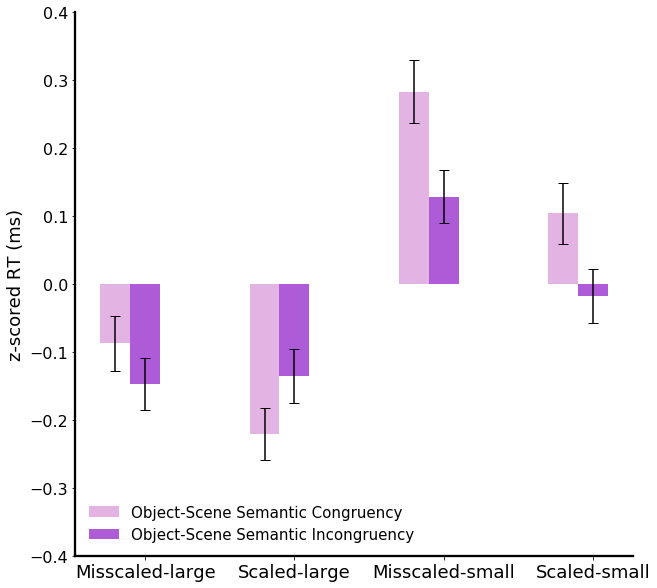

In [88]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

#                                          Misscaled                                             Scaled
#                               large                          small                         large                     small

RT_objSemCong =   [misscaled_zo_objSemCong_RT, scaled_zo_objSemCong_RT, misscaled_zi_objSemCong_RT, scaled_zi_objSemCong_RT]
# RT_objSemCong_sem = [0.054887166,  0.059011359, 0.056598741,  0.053137745]
RT_objSemCong_sem = [misscaled_zo_objSemCong_RT_sem, scaled_zo_objSemCong_RT_sem, misscaled_zi_objSemCong_RT_sem, scaled_zi_objSemCong_RT_sem]


RT_objSemIncong = [misscaled_zo_objSemIncong_RT, scaled_zo_objSemIncong_RT, misscaled_zi_objSemIncong_RT, scaled_zi_objSemIncong_RT]
# RT_objSemIncong_sem = [0.054683928, 0.052511237, 0.061406205,  0.071207949]
RT_objSemIncong_sem = [misscaled_zo_objSemIncong_RT_sem, scaled_zo_objSemIncong_RT_sem, misscaled_zi_objSemIncong_RT_sem, scaled_zi_objSemIncong_RT_sem]





width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_objSemCong, width, color='plum', label='Object-Scene Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
plt.bar(x, RT_objSemIncong, width, color='darkorchid', label='Object-Scene Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled-large', 'Scaled-large', 'Misscaled-small', 'Scaled-small'], fontsize='18')
plt.ylim(-0.4, 0.3)
plt.yticks(np.arange(-0.4,0.5, .1),fontsize=16) 
plt.ylabel("z-scored RT (ms)", fontsize=18)
plt.legend(loc=3, fontsize=15, frameon=False)
# plt.title('E5V2-RT', fontsize=22)
plt.show()

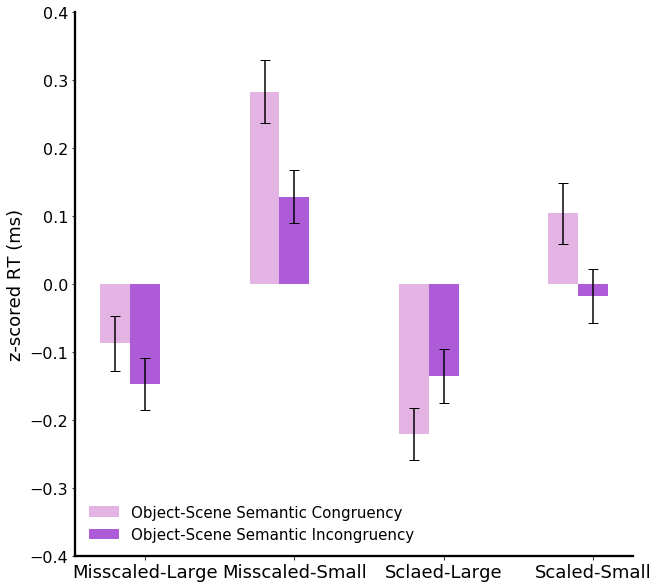

In [98]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

RT_objSemCong =   [misscaled_zo_objSemCong_RT, misscaled_zi_objSemCong_RT, scaled_zo_objSemCong_RT, scaled_zi_objSemCong_RT]
# RT_objSemCong_sem = [0.054887166,  0.059011359, 0.056598741,  0.053137745]
RT_objSemCong_sem = [misscaled_zo_objSemCong_RT_sem, misscaled_zi_objSemCong_RT_sem, scaled_zo_objSemCong_RT_sem, scaled_zi_objSemCong_RT_sem]


RT_objSemIncong = [misscaled_zo_objSemIncong_RT, misscaled_zi_objSemIncong_RT, scaled_zo_objSemIncong_RT, scaled_zi_objSemIncong_RT]
# RT_objSemIncong_sem = [0.054683928, 0.052511237, 0.061406205,  0.071207949]
RT_objSemIncong_sem = [misscaled_zo_objSemIncong_RT_sem,  misscaled_zi_objSemIncong_RT_sem, scaled_zo_objSemIncong_RT_sem, scaled_zi_objSemIncong_RT_sem]





width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_objSemCong, width, color='plum', label='Object-Scene Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
plt.bar(x, RT_objSemIncong, width, color='darkorchid', label='Object-Scene Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled-Large', 'Misscaled-Small', 'Sclaed-Large',  'Scaled-Small'], fontsize='18')
plt.ylim(-0.4, 0.3)
plt.yticks(np.arange(-0.4,0.5, .1),fontsize=16) 
plt.ylabel("z-scored RT (ms)", fontsize=18)
plt.legend(loc=3, fontsize=15, frameon=False)
# plt.figtext(0.99, 0.01, 'footnote text', horizontalalignment='center')
# plt.title('E5V2-RT', fontsize=22)
plt.show()

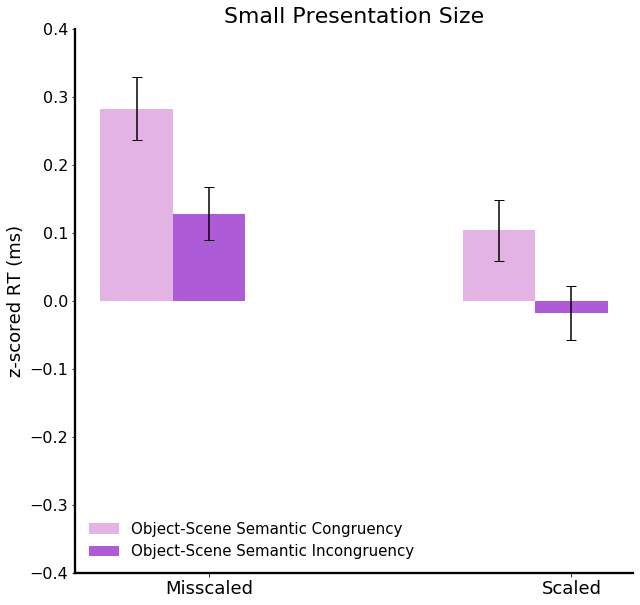

In [91]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(2)

RT_objSemCong =   [misscaled_zi_objSemCong_RT, scaled_zi_objSemCong_RT]
# RT_objSemCong_sem = [0.054887166,  0.059011359, 0.056598741,  0.053137745]
RT_objSemCong_sem = [misscaled_zi_objSemCong_RT_sem, scaled_zi_objSemCong_RT_sem]


RT_objSemIncong = [misscaled_zi_objSemIncong_RT, scaled_zi_objSemIncong_RT]
# RT_objSemIncong_sem = [0.054683928, 0.052511237, 0.061406205,  0.071207949]
RT_objSemIncong_sem = [misscaled_zi_objSemIncong_RT_sem, scaled_zi_objSemIncong_RT_sem]


width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_objSemCong, width, color='plum', label='Object-Scene Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
plt.bar(x, RT_objSemIncong, width, color='darkorchid', label='Object-Scene Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled', 'Scaled'], fontsize='18')
plt.ylim(-0.4, 0.3)
plt.yticks(np.arange(-0.4,0.5, .1),fontsize=16) 
plt.ylabel("z-scored RT (ms)", fontsize=18)
plt.legend(loc=3, fontsize=15, frameon=False)
plt.title('Small Presentation Size', fontsize=22)
plt.show()

In [50]:
# misscaled_zo_objSemCong_CO, scaled_zo_objSemCong_CO, misscaled_zi_objSemCong_CO, scaled_zi_objSemCong_CO
# misscaled_zo_objSemIncong_CO, scaled_zo_objSemIncong_CO, misscaled_zi_objSemIncong_CO, scaled_zi_objSemIncong_CO


In [51]:
def summary_stats_byRating(data):
    '''
    returns the averages and ste for each rating (1-7)
    '''

    ratings = [1, 2, 3, 4, 5, 6, 7]

    avg_zs_rt = []
    ste_zs_rt = []
    for rat in ratings:
        r_data = data.loc[data['rating']==rat]

        avg = np.mean(np.array(r_data['Z-Scored RT']))
        avg_zs_rt.append(avg)
        ste = sem(np.array(r_data['Z-Scored RT']))
        ste_zs_rt.append(ste)

    return avg_zs_rt, ste_zs_rt    
    

In [52]:
avg_perRating_misscaled_zo_objSemCong_RT, ste_perRating_misscaled_zo_objSemCong_RT = summary_stats_byRating(misscaled_zo_objSemCong_CO)
avg_perRating_misscaled_zo_objSemIncong_RT, ste_perRating_misscaled_zo_objSemIncong_RT = summary_stats_byRating(misscaled_zo_objSemIncong_CO)

avg_perRating_misscaled_zi_objSemCong_RT, ste_perRating_misscaled_zi_objSemCong_RT = summary_stats_byRating(misscaled_zi_objSemCong_CO)
avg_perRating_misscaled_zi_objSemIncong_RT, ste_perRating_misscaled_zi_objSemIncong_RT = summary_stats_byRating(misscaled_zi_objSemIncong_CO)

avg_perRating_scaled_zo_objSemCong_RT, ste_perRating_scaled_zo_objSemCong_RT = summary_stats_byRating(scaled_zo_objSemCong_CO)
avg_perRating_scaled_zo_objSemIncong_RT, ste_perRating_scaled_zo_objSemIncong_RT = summary_stats_byRating(scaled_zo_objSemIncong_CO)

avg_perRating_scaled_zi_objSemCong_RT, ste_perRating_scaled_zi_objSemCong_RT = summary_stats_byRating(scaled_zi_objSemCong_CO)
avg_perRating_scaled_zi_objSemIncong_RT, ste_perRating_scaled_zi_objSemIncong_RT = summary_stats_byRating(scaled_zi_objSemIncong_CO)

/Users/prachimahableshwarkar/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/prachimahableshwarkar/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/prachimahableshwarkar/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/prachimahableshwarkar/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/prachimahableshwarkar/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)


In [53]:
# fig, ax = plt.subplots(figsize=[15,10])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for axis in ['bottom','left']:
#     ax.spines[axis].set_linewidth(2.3)
    
# x = np.arange(4)


# RT_objSemCong =   [misscaled_zo_objSemCong_RT, scaled_zo_objSemCong_RT, misscaled_zi_objSemCong_RT, scaled_zi_objSemCong_RT]
# RT_objSemCong_sem = [0.054887166,  0.059011359, 0.056598741,  0.053137745]

# RT_objSemIncong = [misscaled_zo_objSemIncong_RT, scaled_zo_objSemIncong_RT, misscaled_zi_objSemIncong_RT, scaled_zi_objSemIncong_RT]
# RT_objSemIncong_sem = [0.054683928, 0.052511237, 0.061406205,  0.071207949]





# width = 0.2
  
# # plot data in grouped manner of bar type
# plt.bar(x-0.2, RT_objSemCong, width, color='plum', label='Object-Scene Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
# plt.bar(x, RT_objSemIncong, width, color='darkorchid', label='Object-Scene Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
# plt.xticks(x, ['Misscaled-large', 'Scaled-large', 'Misscaled-small', 'Scaled-small'], fontsize='18')

# # Points data (you need to replace these with your pre-defined values)
# points_x = []
# points_y = []
# points_ste = []
# point_labels = []

# your_predefined_values_for_RT_objSemCong = [avg_perRating_misscaled_zo_objSemCong_RT, avg_perRating_scaled_zo_objSemCong_RT, avg_perRating_misscaled_zi_objSemCong_RT, avg_perRating_scaled_zi_objSemCong_RT]
# your_predefined_values_for_RT_objSemIncong = [avg_perRating_misscaled_zo_objSemIncong_RT, avg_perRating_scaled_zo_objSemIncong_RT, avg_perRating_misscaled_zi_objSemIncong_RT, avg_perRating_scaled_zi_objSemIncong_RT]


# ste_your_predefined_values_for_RT_objSemCong = [ste_perRating_misscaled_zo_objSemCong_RT, ste_perRating_scaled_zo_objSemCong_RT, ste_perRating_misscaled_zi_objSemCong_RT, ste_perRating_scaled_zi_objSemCong_RT]
# ste_your_predefined_values_for_RT_objSemIncong = [ste_perRating_misscaled_zo_objSemIncong_RT, ste_perRating_scaled_zo_objSemIncong_RT, ste_perRating_misscaled_zi_objSemIncong_RT, ste_perRating_scaled_zi_objSemIncong_RT]


# # Replace the following with your actual data
# for i in range(len(x)):
#     # Pre-defined values for the 7 points for each bar
#     points_x.extend([x[i] - 0.15] * 7)
#     points_y.extend(your_predefined_values_for_RT_objSemCong[i])
#     points_ste.extend(ste_your_predefined_values_for_RT_objSemCong[i])
#     point_labels.extend([str(j + 1) for j in range(7)])
    
#     points_x.extend([x[i] + 0.05] * 7)
#     points_y.extend(your_predefined_values_for_RT_objSemIncong[i])
#     points_ste.extend(ste_your_predefined_values_for_RT_objSemIncong[i])
#     point_labels.extend([str(j + 1) for j in range(7)])

# # Colors for the points (you can modify the colors as desired)
# point_colors = ['navy', 'mediumblue', 'royalblue', 'cornflowerblue', 'gold', 'darkorange', 'red']

# # Plotting the points with error bars for each bar
# for i in range(len(points_x)):
# #     plt.errorbar(points_x[i], points_y[i], yerr=points_ste[i], color=point_colors[i % 7], fmt='o', markersize=5, capsize=5, label=point_labels[i])
# #     plt.scatter(points_x[i], points_y[i], color=point_colors[i % 7], s=50, marker='o', label=point_labels[i])
#     plt.scatter(points_x[i], points_y[i], color=point_colors[i % 7], s=50, marker='o')

# plt.ylim(-0.4, 0.3)
# plt.yticks(np.arange(-0.4,0.5, .1),fontsize=16) 
# plt.ylabel("z-scored RT (ms)", fontsize=18)
# plt.legend(loc=0, fontsize=15, frameon=False)
# # plt.title('E5V2-RT', fontsize=22)
# plt.show()

In [54]:
print(stats.mode(list(misscaled_zo_objSemCong_CO['rating'])), np.mean(np.array(list(misscaled_zo_objSemCong_CO['rating']))))
print(stats.mode(list(misscaled_zo_objSemIncong_CO['rating'])), np.mean(np.array(list(misscaled_zo_objSemIncong_CO['rating']))))

print(stats.mode(list(scaled_zo_objSemCong_CO['rating'])), np.mean(np.array(list(scaled_zo_objSemCong_CO['rating']))))
print(stats.mode(list(scaled_zo_objSemIncong_CO['rating'])), np.mean(np.array(list(scaled_zo_objSemIncong_CO['rating']))))

print(stats.mode(list(misscaled_zi_objSemCong_CO['rating'])), np.mean(np.array(list(misscaled_zi_objSemCong_CO['rating']))))
print(stats.mode(list(misscaled_zi_objSemIncong_CO['rating'])), np.mean(np.array(list(misscaled_zi_objSemIncong_CO['rating']))))

print(stats.mode(list(scaled_zi_objSemCong_CO['rating'])), np.mean(np.array(list(scaled_zi_objSemCong_CO['rating']))))
print(stats.mode(list(scaled_zi_objSemIncong_CO['rating'])), np.mean(np.array(list(scaled_zi_objSemIncong_CO['rating']))))

ModeResult(mode=array([7]), count=array([271])) 5.816029143897996
ModeResult(mode=array([7]), count=array([281])) 5.85251798561151
ModeResult(mode=array([4]), count=array([295])) 4.551470588235294
ModeResult(mode=array([4]), count=array([295])) 4.671378091872792
ModeResult(mode=array([1]), count=array([184])) 2.3434535104364325
ModeResult(mode=array([1]), count=array([180])) 2.3927272727272726
ModeResult(mode=array([4]), count=array([243])) 3.643510054844607
ModeResult(mode=array([4]), count=array([240])) 3.729281767955801


ModeResult(mode=array([7]), count=array([271]))
ModeResult(mode=array([7]), count=array([281]))


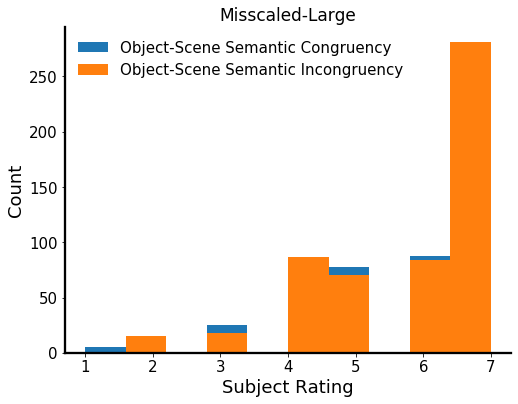

In [55]:
fig, ax = plt.subplots(figsize=[8,6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = list(misscaled_zo_objSemCong_CO['rating'])
print(stats.mode(x))

y = list(misscaled_zo_objSemIncong_CO['rating'])
print(stats.mode(y))

plt.title('Misscaled-Large',fontsize=17)
plt.yticks(fontsize=15) 
plt.xticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Count", fontsize=18)

plt.hist(x, label='Object-Scene Semantic Congruency')
plt.hist(y, label='Object-Scene Semantic Incongruency')

plt.legend(loc=0, fontsize=15, frameon=False)

plt.show()


In [56]:
RTs_correctOnly = list(final_data_correctOnly['RT']) 

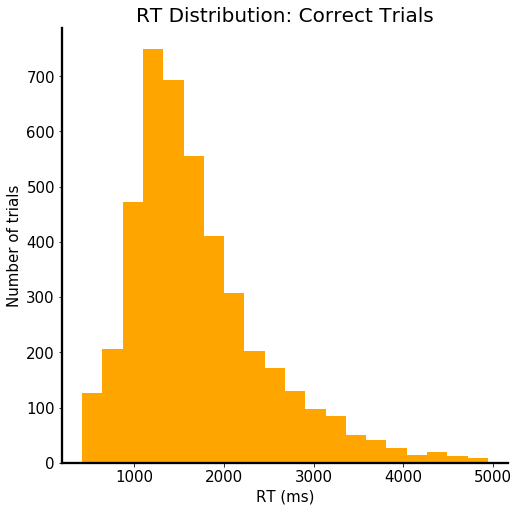

In [57]:

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)



for axis in ['bottom','left']:

    ax.spines[axis].set_linewidth(2.3)

plt.hist(np.array(RTs_correctOnly), color='orange', bins=20)
plt.title('RT Distribution: Correct Trials', fontsize=20)
plt.xlabel('RT (ms)', fontsize=15)
plt.ylabel('Number of trials', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Average Rating x zsRT per Object-Scene Pair

In [58]:
misscaled_zi_objSemCong_CO.columns

Index(['subjID', 'experimentName', 'versionName', 'sequenceName',
       'Z-Scored RT', 'windowWidth', 'windowHeight', 'screenWidth',
       'screenHeight', 'startDate', 'startTime', 'pracTries', 'trialNum',
       'scene', 'size_name', 'image_name', 'object', 'side', 'objectCategory',
       'objSceneSemCong', 'scale', 'image', 'presentationSize', 'keyPress',
       'accuracy', 'RT', 'ratingTrialNum', 'rating', 'thisRatingTrialFile',
       'experimentTime', 'totalTime', 'age', 'gender'],
      dtype='object')

In [59]:
# data: misscaled_zi_CO, scaled_zi_CO
# all RTs for object-scene pairs

RT_by_obj_scene_pair_ms_sm = {}

for index, row in misscaled_zi_objSemCong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in RT_by_obj_scene_pair_ms_sm.keys():
        RT_by_obj_scene_pair_ms_sm[obj_scene_pair] = [row['Z-Scored RT']]
    else:
        RT_by_obj_scene_pair_ms_sm[obj_scene_pair].append(row['Z-Scored RT'])

RT_by_obj_scene_pair_s_sm = {}

for index, row in scaled_zi_objSemCong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in RT_by_obj_scene_pair_s_sm.keys():
        RT_by_obj_scene_pair_s_sm[obj_scene_pair] = [row['Z-Scored RT']]
    else:
        RT_by_obj_scene_pair_s_sm[obj_scene_pair].append(row['Z-Scored RT'])

In [60]:
# data: misscaled_zi_CO, scaled_zi_CO
# all ratings for object-scene pairs

rating_by_obj_scene_pair_ms_sm = {}

for index, row in misscaled_zi_objSemCong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in rating_by_obj_scene_pair_ms_sm.keys():
        rating_by_obj_scene_pair_ms_sm[obj_scene_pair] = [row['rating']]
    else:
        rating_by_obj_scene_pair_ms_sm[obj_scene_pair].append(row['rating'])

rating_by_obj_scene_pair_s_sm = {}

for index, row in scaled_zi_objSemCong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in rating_by_obj_scene_pair_s_sm.keys():
        rating_by_obj_scene_pair_s_sm[obj_scene_pair] = [row['rating']]
    else:
        rating_by_obj_scene_pair_s_sm[obj_scene_pair].append(row['rating'])

In [61]:
combined_dict_ms_sm = {key: [RT_by_obj_scene_pair_ms_sm[key], rating_by_obj_scene_pair_ms_sm[key]] for key in RT_by_obj_scene_pair_ms_sm}

combined_dict_s_sm = {key: [RT_by_obj_scene_pair_s_sm[key], rating_by_obj_scene_pair_s_sm[key]] for key in RT_by_obj_scene_pair_s_sm}


In [62]:
avgs_ms_sm = {}

for key in combined_dict_ms_sm:
    avg_rt = np.mean(np.array(combined_dict_ms_sm[key][0]))
    ste_rt = sem(np.array(combined_dict_ms_sm[key][0]))
    avg_rating = np.mean(np.array(combined_dict_ms_sm[key][1]))
    
    avgs_ms_sm[key] = [avg_rt, ste_rt, avg_rating]

avgs_s_sm = {}

for key in combined_dict_s_sm:
    avg_rt = np.mean(np.array(combined_dict_s_sm[key][0]))
    ste_rt = sem(np.array(combined_dict_s_sm[key][0]))
    avg_rating = np.mean(np.array(combined_dict_s_sm[key][1]))
    
    avgs_s_sm[key] = [avg_rt, ste_rt, avg_rating]

In [63]:
len(avgs_ms_sm.keys())


72

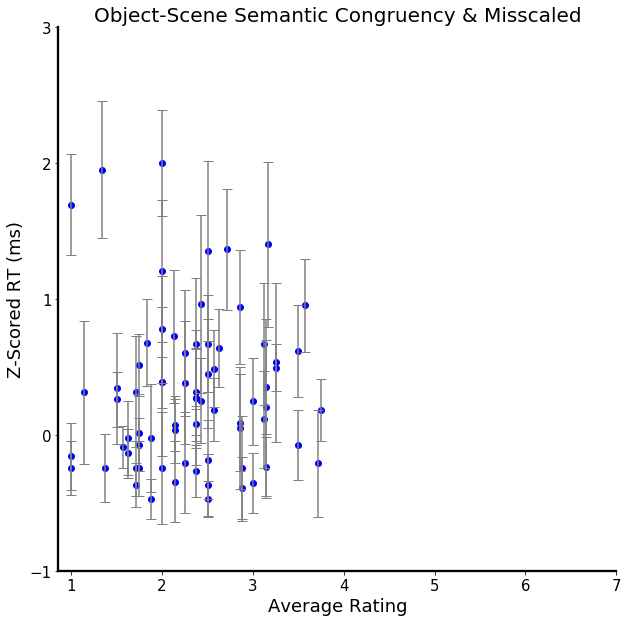

In [64]:
data = avgs_ms_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='blue', label='Data Points')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5, label='Standard Error')

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)
plt.title('Object-Scene Semantic Congruency & Misscaled', fontsize=20)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
# plt.legend()

# Show plot
plt.show()

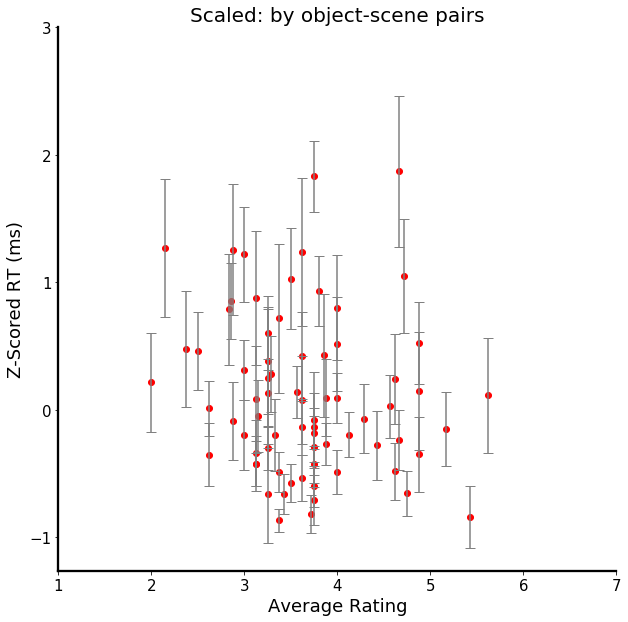

In [65]:
data = avgs_s_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='red', label='Data Points')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5, label='Standard Error')

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)
plt.title('Scaled: by object-scene pairs', fontsize=20)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
# plt.legend()

# Show plot
plt.show()

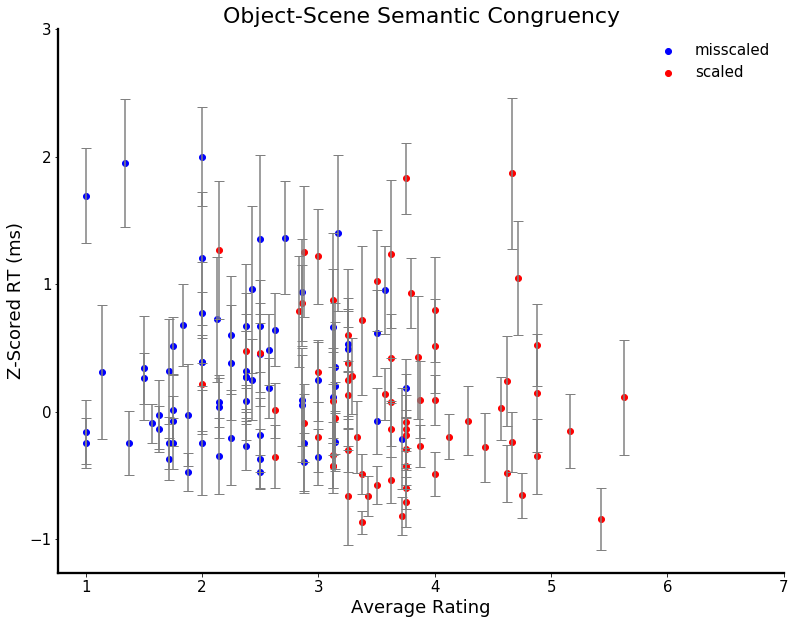

In [66]:
data = avgs_ms_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[13,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='blue', label='misscaled')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5)

data = avgs_s_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

plt.scatter(x, y, marker='o', color='red', label='scaled')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5)

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
plt.legend(loc=0, fontsize=15, frameon=False)

plt.title('Object-Scene Semantic Congruency', fontsize=22)


# Show plot
plt.show()

In [67]:
misscaled_zi_objSemCong_CO.columns

Index(['subjID', 'experimentName', 'versionName', 'sequenceName',
       'Z-Scored RT', 'windowWidth', 'windowHeight', 'screenWidth',
       'screenHeight', 'startDate', 'startTime', 'pracTries', 'trialNum',
       'scene', 'size_name', 'image_name', 'object', 'side', 'objectCategory',
       'objSceneSemCong', 'scale', 'image', 'presentationSize', 'keyPress',
       'accuracy', 'RT', 'ratingTrialNum', 'rating', 'thisRatingTrialFile',
       'experimentTime', 'totalTime', 'age', 'gender'],
      dtype='object')

In [68]:
# data: misscaled_zi_CO, scaled_zi_CO
# all RTs for object-scene pairs

RT_by_obj_scene_pair_ms_sm = {}

for index, row in misscaled_zi_objSemIncong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in RT_by_obj_scene_pair_ms_sm.keys():
        RT_by_obj_scene_pair_ms_sm[obj_scene_pair] = [row['Z-Scored RT']]
    else:
        RT_by_obj_scene_pair_ms_sm[obj_scene_pair].append(row['Z-Scored RT'])

RT_by_obj_scene_pair_s_sm = {}

for index, row in scaled_zi_objSemIncong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in RT_by_obj_scene_pair_s_sm.keys():
        RT_by_obj_scene_pair_s_sm[obj_scene_pair] = [row['Z-Scored RT']]
    else:
        RT_by_obj_scene_pair_s_sm[obj_scene_pair].append(row['Z-Scored RT'])

In [69]:
# data: misscaled_zi_CO, scaled_zi_CO
# all ratings for object-scene pairs

rating_by_obj_scene_pair_ms_sm = {}

for index, row in misscaled_zi_objSemIncong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in rating_by_obj_scene_pair_ms_sm.keys():
        rating_by_obj_scene_pair_ms_sm[obj_scene_pair] = [row['rating']]
    else:
        rating_by_obj_scene_pair_ms_sm[obj_scene_pair].append(row['rating'])

rating_by_obj_scene_pair_s_sm = {}

for index, row in scaled_zi_objSemIncong_CO.iterrows():
    obj_scene_pair = str(row['object'] + '_' + row['scene'])
    if obj_scene_pair not in rating_by_obj_scene_pair_s_sm.keys():
        rating_by_obj_scene_pair_s_sm[obj_scene_pair] = [row['rating']]
    else:
        rating_by_obj_scene_pair_s_sm[obj_scene_pair].append(row['rating'])

In [70]:
combined_dict_ms_sm = {key: [RT_by_obj_scene_pair_ms_sm[key], rating_by_obj_scene_pair_ms_sm[key]] for key in RT_by_obj_scene_pair_ms_sm}

combined_dict_s_sm = {key: [RT_by_obj_scene_pair_s_sm[key], rating_by_obj_scene_pair_s_sm[key]] for key in RT_by_obj_scene_pair_s_sm}


In [71]:
avgs_ms_sm = {}

for key in combined_dict_ms_sm:
    avg_rt = np.mean(np.array(combined_dict_ms_sm[key][0]))
    ste_rt = sem(np.array(combined_dict_ms_sm[key][0]))
    avg_rating = np.mean(np.array(combined_dict_ms_sm[key][1]))
    
    avgs_ms_sm[key] = [avg_rt, ste_rt, avg_rating]

avgs_s_sm = {}

for key in combined_dict_s_sm:
    avg_rt = np.mean(np.array(combined_dict_s_sm[key][0]))
    ste_rt = sem(np.array(combined_dict_s_sm[key][0]))
    avg_rating = np.mean(np.array(combined_dict_s_sm[key][1]))
    
    avgs_s_sm[key] = [avg_rt, ste_rt, avg_rating]

In [72]:
len(avgs_ms_sm.keys())


72

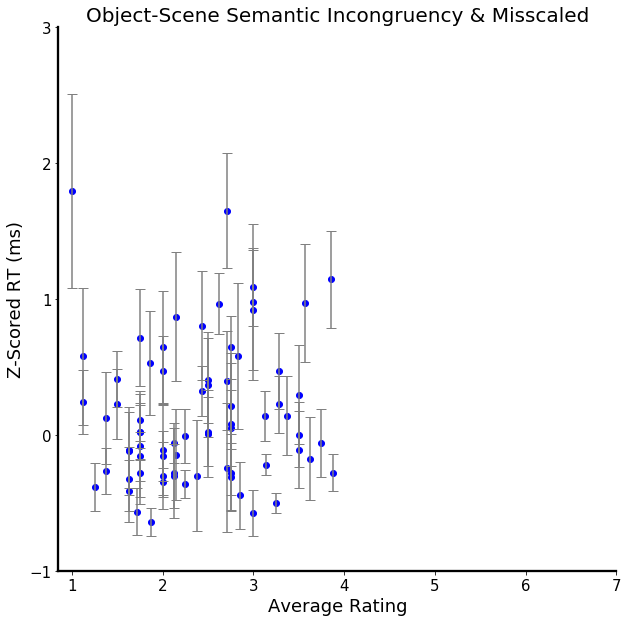

In [73]:
data = avgs_ms_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='blue', label='Data Points')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5, label='Standard Error')

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)
plt.title('Object-Scene Semantic Incongruency & Misscaled', fontsize=20)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
# plt.legend()

# Show plot
plt.show()

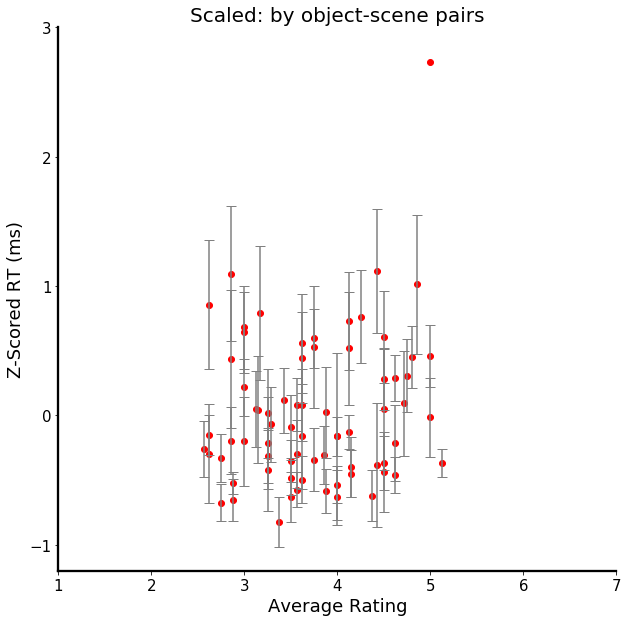

In [74]:
data = avgs_s_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='red', label='Data Points')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5, label='Standard Error')

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)
plt.title('Scaled: by object-scene pairs', fontsize=20)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
# plt.legend()

# Show plot
plt.show()

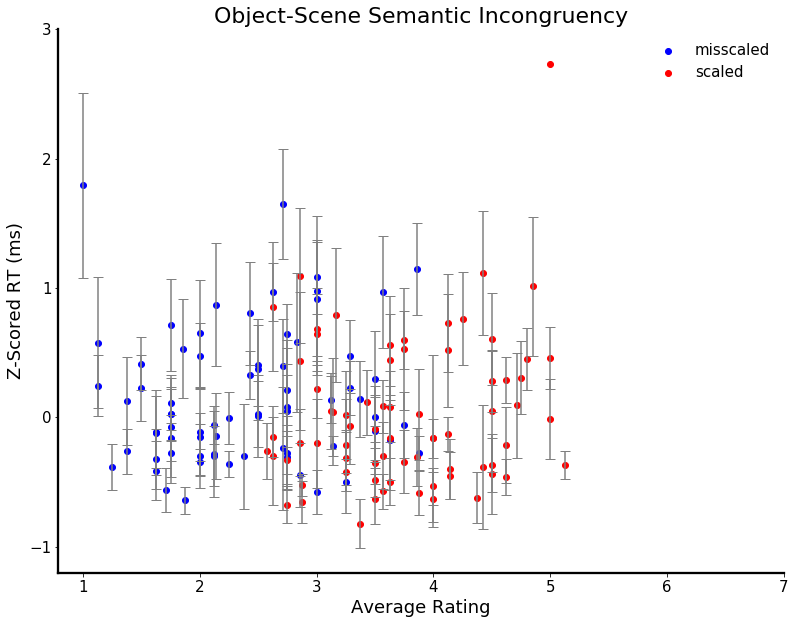

In [75]:
data = avgs_ms_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

# Create scatterplot

fig, ax = plt.subplots(figsize=[13,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.scatter(x, y, marker='o', color='blue', label='misscaled')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5)

data = avgs_s_sm

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Extract x (last value) and y (first value) coordinates
x = [item[2] for item in values]
y = [item[0] for item in values]

# Extract standard error for error bars
error = [item[1] for item in values]

plt.scatter(x, y, marker='o', color='red', label='scaled')

# Add error bars
plt.errorbar(x, y, yerr=error, linestyle='None', color='gray', capsize=5)

# Set labels and title
plt.xlabel('Average Rating', fontsize=18)
plt.ylabel('Z-Scored RT (ms)', fontsize=18)

plt.xticks(np.arange(1,8,1),fontsize=15)
plt.yticks(np.arange(-1,4,1),fontsize=15)

# Add legend
plt.legend(loc=0, fontsize=15, frameon=False)

plt.title('Object-Scene Semantic Incongruency', fontsize=22)

# Show plot
plt.show()

## Inverse Efficiency Score 

RT/acc

In [112]:
zo_df_NCO = final_data.loc[final_data['presentationSize']=='large']
zi_df_NCO = final_data.loc[final_data['presentationSize']=='small']

zo_NCO_RT = np.mean(np.array(zo_df_NCO['RT']))
zi_NCO_RT = np.mean(np.array(zi_df_NCO['RT']))

misscaled_zo_NCO = zo_df_NCO.loc[zo_df_NCO['scale'] =='misscaled'] 
misscaled_zi_NCO = zi_df_NCO.loc[zi_df_NCO['scale'] =='misscaled']
misscaled_NCO = misscaled_zo_NCO.append(misscaled_zi_NCO)

scaled_zo_NCO = zo_df_NCO.loc[zo_df_NCO['scale'] =='scaled'] 
scaled_zi_NCO = zi_df_NCO.loc[zi_df_NCO['scale'] =='scaled']
scaled_NCO = scaled_zo_NCO.append(scaled_zi_NCO)


# misscaled
misscaled_zo_objSemCong_NCO = misscaled_zo_NCO.loc[misscaled_zo_NCO["objSceneSemCong"]==1]
misscaled_zo_objSemIncong_NCO = misscaled_zo_NCO.loc[misscaled_zo_NCO["objSceneSemCong"]==0]

misscaled_zo_objSemCong_NCO_RT = np.mean(np.array(misscaled_zo_objSemCong_NCO['RT']))
misscaled_zo_objSemIncong_NCO_RT = np.mean(np.array(misscaled_zo_objSemIncong_NCO['RT']))

misscaled_zo_objSemCong_NCO_RT_sem = sem(np.array(misscaled_zo_objSemCong_NCO['RT']))
misscaled_zo_objSemIncong_NCO_RT_sem = sem(np.array(misscaled_zo_objSemIncong_NCO['RT']))


misscaled_zi_objSemCong_NCO = misscaled_zi_NCO.loc[misscaled_zi_NCO["objSceneSemCong"]==1]
misscaled_zi_objSemIncong_NCO = misscaled_zi_NCO.loc[misscaled_zi_NCO["objSceneSemCong"]==0]

misscaled_zi_objSemCong_NCO_RT = np.mean(np.array(misscaled_zi_objSemCong_NCO['RT']))
misscaled_zi_objSemIncong_NCO_RT = np.mean(np.array(misscaled_zi_objSemIncong_NCO['RT']))

misscaled_zi_objSemCong_NCO_RT_sem = sem(np.array(misscaled_zi_objSemCong_NCO['RT']))
misscaled_zi_objSemIncong_NCO_RT_sem = sem(np.array(misscaled_zi_objSemIncong_NCO['RT']))


# scaled
scaled_zo_objSemCong_NCO = scaled_zo_NCO.loc[scaled_zo_NCO["objSceneSemCong"]==1]
scaled_zo_objSemIncong_NCO = scaled_zo_NCO.loc[scaled_zo_NCO["objSceneSemCong"]==0]

scaled_zo_objSemCong_NCO_RT = np.mean(np.array(scaled_zo_objSemCong_NCO['RT']))
scaled_zo_objSemIncong_NCO_RT = np.mean(np.array(scaled_zo_objSemIncong_NCO['RT']))

scaled_zo_objSemCong_NCO_RT_sem = sem(np.array(scaled_zo_objSemCong_NCO['RT']))
scaled_zo_objSemIncong_NCO_RT_sem = sem(np.array(scaled_zo_objSemIncong_NCO['RT']))


scaled_zi_objSemCong_NCO = scaled_zi_NCO.loc[scaled_zi_NCO["objSceneSemCong"]==1]
scaled_zi_objSemIncong_NCO = scaled_zi_NCO.loc[scaled_zi_NCO["objSceneSemCong"]==0]

scaled_zi_objSemCong_NCO_RT = np.mean(np.array(scaled_zi_objSemCong_NCO['RT']))
scaled_zi_objSemIncong_NCO_RT = np.mean(np.array(scaled_zi_objSemIncong_NCO['RT']))

scaled_zi_objSemCong_NCO_RT_sem = sem(np.array(scaled_zi_objSemCong_NCO['RT']))
scaled_zi_objSemIncong_NCO_RT_sem = sem(np.array(scaled_zi_objSemIncong_NCO['RT']))

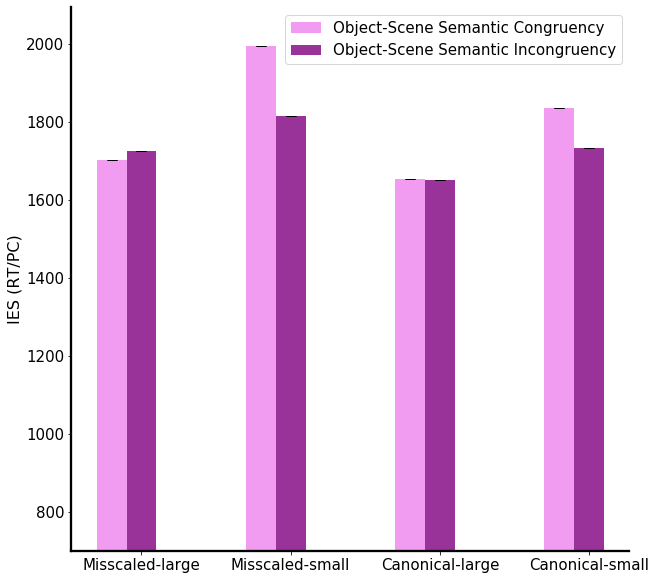

In [43]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

IES_objSemCong =   [misscaled_zo_objSemCong_NCO_RT/misscaled_zo_objSemCong_acc, misscaled_zi_objSemCong_NCO_RT/misscaled_zi_objSemCong_acc, scaled_zo_objSemCong_NCO_RT/scaled_zo_objSemCong_acc, scaled_zi_objSemCong_NCO_RT/scaled_zi_objSemCong_acc]
IES_objSemCong_sem = [misscaled_zo_objSemCong_NCO_RT_sem/misscaled_zo_objSemCong_sem, misscaled_zi_objSemCong_NCO_RT_sem/misscaled_zi_objSemCong_sem, scaled_zo_objSemCong_NCO_RT_sem/scaled_zo_objSemCong_sem, scaled_zi_objSemCong_NCO_RT_sem/scaled_zi_objSemCong_sem]

IES_objSemIncong = [misscaled_zo_objSemIncong_NCO_RT/misscaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_NCO_RT/misscaled_zi_objSemIncong_acc, scaled_zo_objSemIncong_NCO_RT/scaled_zo_objSemIncong_acc, scaled_zi_objSemIncong_NCO_RT/scaled_zi_objSemIncong_acc]
IES_objSemIncong_sem = [misscaled_zo_objSemIncong_NCO_RT_sem/misscaled_zo_objSemIncong_sem, misscaled_zi_objSemIncong_NCO_RT_sem/misscaled_zi_objSemIncong_sem, scaled_zo_objSemIncong_NCO_RT_sem/scaled_zo_objSemIncong_sem, scaled_zi_objSemIncong_NCO_RT_sem/scaled_zi_objSemIncong_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, IES_objSemCong, width, color='violet', label='Object-Scene Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
plt.bar(x, IES_objSemIncong, width, color='purple', label='Object-Scene Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled-large', 'Misscaled-small', 'Canonical-large', 'Canonical-small'], fontsize='15')
plt.yticks(fontsize=15) 
plt.ylim(700)
plt.ylabel("IES (RT/PC)", fontsize=16)
plt.legend(loc=0, fontsize=15)
plt.show()

In [55]:
ies_data = {'misscaled_presentationSizeLarge_objSceneSemCong': misscaled_zo_objSemCong_NCO_RT/misscaled_zo_objSemCong_acc,
            'misscaled_presentationSizeSmall_objSceneSemCong': misscaled_zi_objSemCong_NCO_RT/misscaled_zi_objSemCong_acc,
            'scaled_presentationSizeLarge_objSceneSemCong': scaled_zo_objSemCong_NCO_RT/scaled_zo_objSemCong_acc,
            'scaled_presentationSizeSmall_objSceneSemCong': scaled_zi_objSemCong_NCO_RT/scaled_zi_objSemCong_acc,
            'misscaled_presentationSizeLarge_objSceneSemIncong': misscaled_zo_objSemIncong_NCO_RT/misscaled_zo_objSemIncong_acc,
            'misscaled_presentationSizeSmall_objSceneSemIncong': misscaled_zi_objSemIncong_NCO_RT/misscaled_zi_objSemIncong_acc,
            'scaled_presentationSizeLarge_objSceneSemIncong': scaled_zo_objSemIncong_NCO_RT/scaled_zo_objSemIncong_acc,
            'scaled_presentationSizeSmall_objSceneSemIncong': scaled_zi_objSemIncong_NCO_RT/scaled_zi_objSemIncong_acc,
        'age': ['5', '10', '7', '6']} 
ies_df = pd.DataFrame.from_dict(ies_data)

In [56]:
ies_df.to_csv('IES_e5v2.csv', index=False)

# Analyze Data by Mis-scaling Rating

In [236]:
data_1 = final_data.loc[final_data['rating'] == 1]
data_2 = final_data.loc[final_data['rating'] == 2]
data_3 = final_data.loc[final_data['rating'] == 3]
data_4 = final_data.loc[final_data['rating'] == 4]




In [237]:
len(data_1['accuracy']), len(data_2['accuracy']), len(data_3['accuracy']), len(data_4['accuracy'])

(244, 167, 166, 697)

In [238]:
len(data_1['accuracy']), len(data_2['accuracy']), len(data_3['accuracy']), len(data_4['accuracy'])


(244, 167, 166, 697)

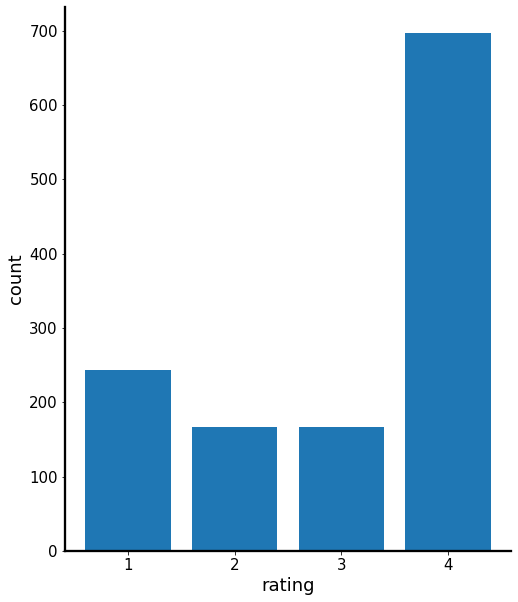

In [239]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks( fontsize='15')
plt.yticks(fontsize=15) 
plt.ylabel('count', fontsize=18)
plt.xlabel('rating', fontsize=18)
    
plt.bar(['1', '2', '3', '4'], [len(data_1['accuracy']), len(data_2['accuracy']), len(data_3['accuracy']), len(data_4['accuracy'])
])
plt.show()

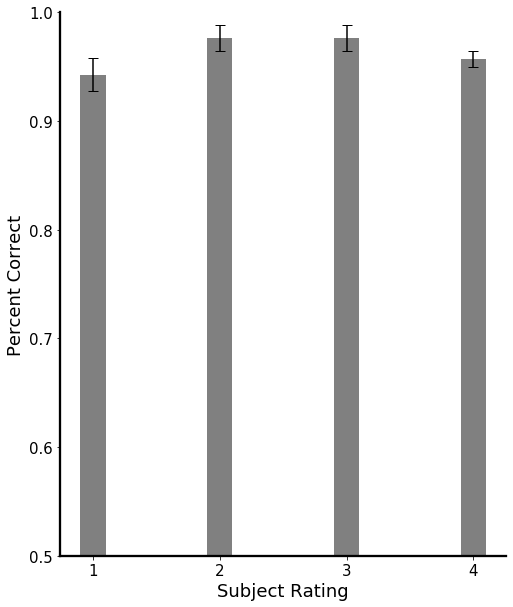

In [240]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

Acc_ =   [np.sum(np.array(data_1['accuracy']))/len(np.array(data_1['accuracy'])), np.sum(np.array(data_2['accuracy']))/len(np.array(data_2['accuracy'])), np.sum(np.array(data_3['accuracy']))/len(np.array(data_3['accuracy'])), np.sum(np.array(data_4['accuracy']))/len(np.array(data_4['accuracy']))]
yerr_ =  [np.std(np.array(data_1['accuracy']))/np.sqrt(len(np.array(data_1['accuracy']))), np.std(np.array(data_2['accuracy']))/np.sqrt(len(np.array(data_2['accuracy']))), np.std(np.array(data_3['accuracy']))/np.sqrt(len(np.array(data_3['accuracy']))), np.std(np.array(data_4['accuracy']))/np.sqrt(len(np.array(data_4['accuracy'])))]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x, Acc_, width, color='gray', yerr=yerr_, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(0.50, 1)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Percent Correct", fontsize=18)
# plt.legend(loc=1, fontsize=15)
plt.show()

In [241]:
# Accuracy

data_1_acc = np.sum(np.array(data_1['accuracy']))/len(np.array(data_1['accuracy']))

data_1_sem = np.std(np.array(data_1['accuracy']))/np.sqrt(len(np.array(data_1['accuracy'])))

print(len(np.array(data_1['accuracy'])))


data_2_acc = np.sum(np.array(data_2['accuracy']))/len(np.array(data_2['accuracy']))

data_2_sem = np.std(np.array(data_2['accuracy']))/np.sqrt(len(np.array(data_2['accuracy'])))

print(len(np.array(data_2['accuracy'])))


data_3_acc = np.sum(np.array(data_3['accuracy']))/len(np.array(data_3['accuracy']))

data_3_sem = np.std(np.array(data_3['accuracy']))/np.sqrt(len(np.array(data_3['accuracy'])))

print(len(np.array(data_3['accuracy'])))

data_4_acc = np.sum(np.array(data_4['accuracy']))/len(np.array(data_4['accuracy']))

data_4_sem = np.std(np.array(data_4['accuracy']))/np.sqrt(len(np.array(data_4['accuracy'])))

print(len(np.array(data_4['accuracy'])))


244
167
166
697


In [242]:
data_1_objectScene1SemanticCongruency0 = data_1.loc[data_1['objSceneSemCong'] == 0]
data_1_objectScene1SemanticCongruency1 = data_1.loc[data_1['objSceneSemCong'] == 1]

data_2_objectScene1SemanticCongruency0 = data_2.loc[data_2['objSceneSemCong'] == 0]
data_2_objectScene1SemanticCongruency1 = data_2.loc[data_2['objSceneSemCong'] == 1]

data_3_objectScene1SemanticCongruency0 = data_3.loc[data_3['objSceneSemCong'] == 0]
data_3_objectScene1SemanticCongruency1 = data_3.loc[data_3['objSceneSemCong'] == 1]

data_4_objectScene1SemanticCongruency0 = data_4.loc[data_4['objSceneSemCong'] == 0]
data_4_objectScene1SemanticCongruency1 = data_4.loc[data_4['objSceneSemCong'] == 1]


In [243]:
# Accuracy

data_1_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))
data_1_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))

data_1_objectScene1SemanticCongruency0_sem = np.std(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])))
data_1_objectScene1SemanticCongruency1_sem = np.std(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_1_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])))

data_2_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))
data_2_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))

data_2_objectScene1SemanticCongruency0_sem = np.std(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])))
data_2_objectScene1SemanticCongruency1_sem = np.std(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_2_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])))

data_3_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))
data_3_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))

data_3_objectScene1SemanticCongruency0_sem = np.std(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])))
data_3_objectScene1SemanticCongruency1_sem = np.std(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_3_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])))

data_4_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))
data_4_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))

data_4_objectScene1SemanticCongruency0_sem = np.std(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])))
data_4_objectScene1SemanticCongruency1_sem = np.std(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_4_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])))


234
176
174
712


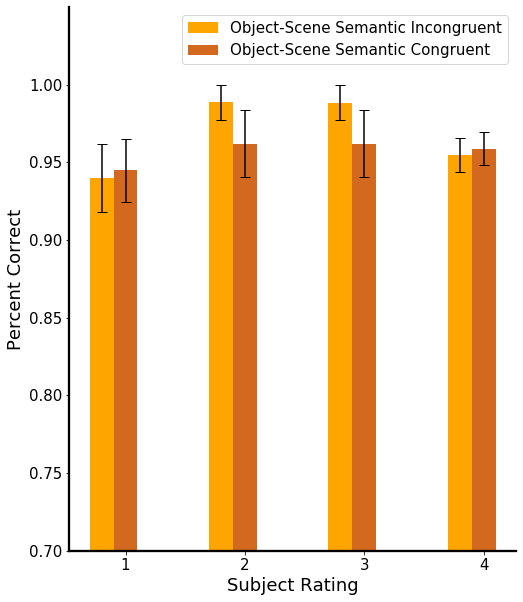

In [244]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

Acc_0 =   [data_1_objectScene1SemanticCongruency0_acc, data_2_objectScene1SemanticCongruency0_acc, data_3_objectScene1SemanticCongruency0_acc, data_4_objectScene1SemanticCongruency0_acc]
yerr_0 =  [data_1_objectScene1SemanticCongruency0_sem, data_2_objectScene1SemanticCongruency0_sem, data_3_objectScene1SemanticCongruency0_sem, data_4_objectScene1SemanticCongruency0_sem]

Acc_1 =   [data_1_objectScene1SemanticCongruency1_acc, data_2_objectScene1SemanticCongruency1_acc, data_3_objectScene1SemanticCongruency1_acc, data_4_objectScene1SemanticCongruency1_acc]
yerr_1 =  [data_1_objectScene1SemanticCongruency1_sem, data_2_objectScene1SemanticCongruency1_sem, data_3_objectScene1SemanticCongruency1_sem, data_4_objectScene1SemanticCongruency1_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_0, width, color='orange', label='Object-Scene Semantic Incongruent', yerr=yerr_0, capsize=5)
plt.bar(x, Acc_1, width, color='chocolate', label='Object-Scene Semantic Congruent', yerr=yerr_1, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(0.70)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

In [245]:
data_1_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 1]
data_2_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 2]
data_3_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 3]
data_4_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 4]





In [246]:
# RT 
data_1_RT = np.mean(np.array(data_1_CO['RT']))

data_1_RT_sem = sem(np.array(data_1_CO['RT']))


data_2_RT = np.mean(np.array(data_2_CO['RT']))

data_2_RT_sem = sem(np.array(data_2_CO['RT']))


data_3_RT = np.mean(np.array(data_3_CO['RT']))

data_3_RT_sem = sem(np.array(data_3_CO['RT']))


data_4_RT = np.mean(np.array(data_4_CO['RT']))

data_4_RT_sem = sem(np.array(data_4_CO['RT']))



In [247]:
len(data_1_CO['accuracy']), len(data_2_CO['accuracy']), len(data_3_CO['accuracy']), len(data_4_CO['accuracy'])

(230, 163, 162, 667)

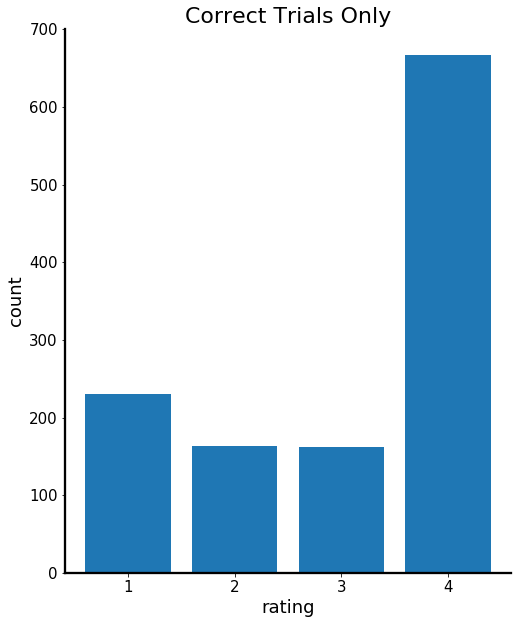

In [248]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks( fontsize='15')
plt.yticks(fontsize=15) 
plt.ylabel('count', fontsize=18)
plt.xlabel('rating', fontsize=18)

plt.title('Correct Trials Only', fontsize=22)
    
plt.bar(['1', '2', '3', '4'], [len(data_1_CO['accuracy']), len(data_2_CO['accuracy']), len(data_3_CO['accuracy']), len(data_4_CO['accuracy'])])

plt.show()

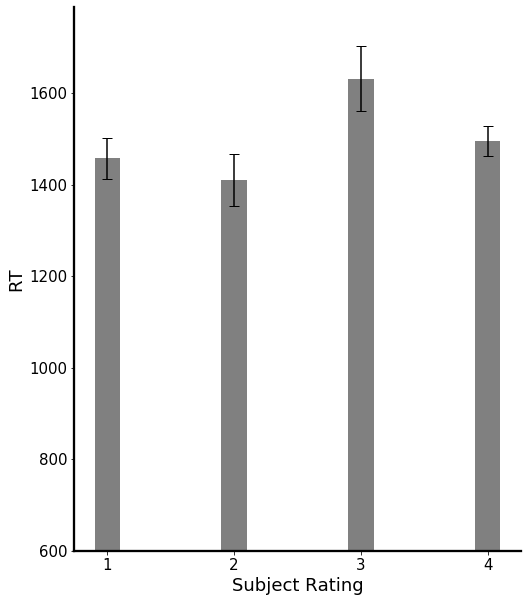

In [249]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

RT_ = [np.mean(np.array(data_1_CO['RT'])), np.mean(np.array(data_2_CO['RT'])), np.mean(np.array(data_3_CO['RT'])), np.mean(np.array(data_4_CO['RT']))]
yerr_RT = [sem(np.array(data_1_CO['RT'])), sem(np.array(data_2_CO['RT'])), sem(np.array(data_3_CO['RT'])), sem(np.array(data_4_CO['RT']))]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x, RT_, width, color='gray', yerr=yerr_RT, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(600)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("RT", fontsize=18)
# plt.legend(loc=1, fontsize=15)
plt.show()

In [250]:
data_1_objectScene1SemanticCongruency0_CO = data_1_CO.loc[data_1_CO['objSceneSemCong'] == 0]
data_1_objectScene1SemanticCongruency1_CO = data_1_CO.loc[data_1_CO['objSceneSemCong'] == 1]

data_2_objectScene1SemanticCongruency0_CO = data_2_CO.loc[data_2_CO['objSceneSemCong'] == 0]
data_2_objectScene1SemanticCongruency1_CO = data_2_CO.loc[data_2_CO['objSceneSemCong'] == 1]

data_3_objectScene1SemanticCongruency0_CO = data_3_CO.loc[data_3_CO['objSceneSemCong'] == 0]
data_3_objectScene1SemanticCongruency1_CO = data_3_CO.loc[data_3_CO['objSceneSemCong'] == 1]

data_4_objectScene1SemanticCongruency0_CO = data_4_CO.loc[data_4_CO['objSceneSemCong'] == 0]
data_4_objectScene1SemanticCongruency1_CO = data_4_CO.loc[data_4_CO['objSceneSemCong'] == 1]


In [251]:
data_1_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_1_objectScene1SemanticCongruency0_CO['RT']))
data_1_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_1_objectScene1SemanticCongruency1_CO['RT']))

data_1_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_1_objectScene1SemanticCongruency0_CO['RT']))
data_1_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_1_objectScene1SemanticCongruency1_CO['RT']))


data_2_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_2_objectScene1SemanticCongruency0_CO['RT']))
data_2_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_2_objectScene1SemanticCongruency1_CO['RT']))

data_2_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_2_objectScene1SemanticCongruency0_CO['RT']))
data_2_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_2_objectScene1SemanticCongruency1_CO['RT']))


data_3_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_3_objectScene1SemanticCongruency0_CO['RT']))
data_3_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_3_objectScene1SemanticCongruency1_CO['RT']))

data_3_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_3_objectScene1SemanticCongruency0_CO['RT']))
data_3_objectScene1SemanticCongruency1_CO_RT_sem =sem(np.array(data_3_objectScene1SemanticCongruency1_CO['RT']))


data_4_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_4_objectScene1SemanticCongruency0_CO['RT']))
data_4_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_4_objectScene1SemanticCongruency1_CO['RT']))

data_4_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_4_objectScene1SemanticCongruency0_CO['RT']))
data_4_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_4_objectScene1SemanticCongruency1_CO['RT']))




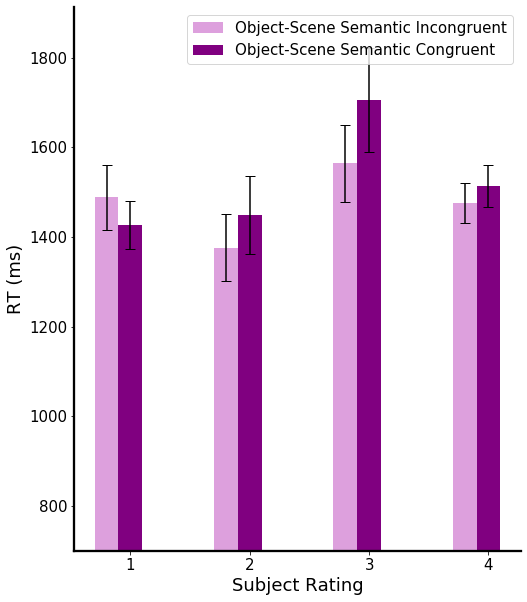

In [252]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

RT_0 =   [data_1_objectScene1SemanticCongruency0_CO_RT, data_2_objectScene1SemanticCongruency0_CO_RT, data_3_objectScene1SemanticCongruency0_CO_RT, data_4_objectScene1SemanticCongruency0_CO_RT]
yerr_RT_0 =  [data_1_objectScene1SemanticCongruency0_CO_RT_sem, data_2_objectScene1SemanticCongruency0_CO_RT_sem, data_3_objectScene1SemanticCongruency0_CO_RT_sem, data_4_objectScene1SemanticCongruency0_CO_RT_sem]

RT_1 =   [data_1_objectScene1SemanticCongruency1_CO_RT, data_2_objectScene1SemanticCongruency1_CO_RT, data_3_objectScene1SemanticCongruency1_CO_RT, data_4_objectScene1SemanticCongruency1_CO_RT]
yerr_RT_1 =  [data_1_objectScene1SemanticCongruency1_CO_RT_sem, data_2_objectScene1SemanticCongruency1_CO_RT_sem, data_3_objectScene1SemanticCongruency1_CO_RT_sem, data_4_objectScene1SemanticCongruency1_CO_RT_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_0, width, color='plum', label='Object-Scene Semantic Incongruent', yerr=yerr_RT_0, capsize=5)
plt.bar(x, RT_1, width, color='purple', label='Object-Scene Semantic Congruent', yerr=yerr_RT_1, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(700)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("RT (ms)", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

## Distribution of Ratings in Mis-scaled and Scaled